<h1 align="center">EPFL Machine Learning Course CS-433 Road Segmentation Project</h1>

<h3 align="center">Efe Tarhan || Sabri Yiğit Arslan || Eren Akçanal</h1>

## Introduction 

## 0. Importing Necessary Libraries

The following are the necessary libraries for this project: 
```markdown
- numpy==1.24.4
- torch==1.13.0  w/ cuda 11.6 
- matplotlib==3.7.5
- scikit-learn==1.3.2
- PIL==10.4.0
- opencv-python==4.10.0
- albumentations==1.4.18
- tqdm==4.67.1
- transformers==4.46.3
- segmentation-models-pytorch==0.3.3
```


In [16]:
import os 
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import sklearn
import tqdm
import albumentations as A 
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

### Setting the random seed for reproducibilty 

In [17]:
random_state = 0
torch.manual_seed(random_state)
np.random.seed(random_state)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The current used device is: " + device.type)

The current used device is: cuda


## 1. Preprocessing of the Dataset and Preparing it for the Task. 

Assuming that the dataset is already unzipped and located in the following assemble of files:  


```plaintext
project/
|
├── train/
│   ├── images/
│   │   ├── satImage_001.png
│   │   ├── satImage_002.png
│   │   ├── satImage_003.png
│   │            .
│   │            .
│   │   ├── satImage_100.png
│   ├── groundtruth/
│   │   ├── satImage_001.png
│   │   ├── satImage_002.png
│   │   ├── satImage_002.png
│   │            .
│   │            .
│   │   ├── satImage_100.png
├── test/
│   │   ├── test_1.png
│   │   ├── test_2.png
│   │   ├── test_3.png
│   │            .
│   │            .
│   │   ├── test_50.png
├── notebooks/
│   │── unet_notebook.ipynb
```

By using considering this file hierarchy the files will be loaded as shown below

### 1.1 Creating a temporary holder for visualizing the dataset

In [18]:
path = "/home/efe/Desktop/ml-project-2-middle_earth/train/"
image_path = path + "images/"
mask_path = path + "groundtruth/" 
target_size = (608,608)

files = os.listdir(image_path)
sorted_image_files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
images = []
for file_name in sorted_image_files:
        image = Image.open(image_path + file_name)
        image = np.array(image).astype(np.float32)
        image = image / 255.0
        images.append(image)

files = os.listdir(mask_path)
sorted_mask_files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
masks = []
for file_name in sorted_mask_files:
        mask = Image.open(mask_path + file_name)
        mask = np.array(mask).astype(np.float32)
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)
        masks.append(mask)

The first image - mask pair in the dataset can be seen below. 

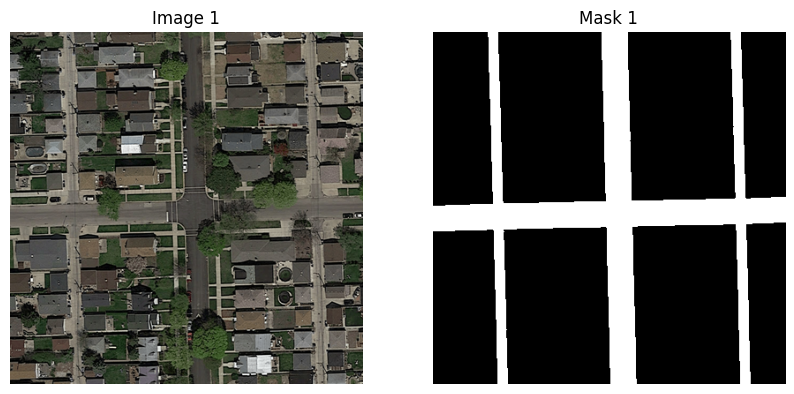

In [19]:
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.title("Image 1")
plt.axis("off")
plt.subplot(1,2,2)  
plt.imshow(masks[0],cmap="gray")
plt.title("Mask 1")
plt.axis("off")
plt.show()

### 1.3 Applying Preprocessing to the Data

These transforms will be applied with 100% probability and therefore the dataset size must be increased. 

### 1.4 Creating the New Custom Dataset Class and Data Loader Functions for Training

In [20]:
path = "/home/efe/Desktop/ml-project-2-middle_earth/train/"
def tr_te_split(root_dir):
    """
    Split the dataset into training and validation sets.
    Args:
        root_dir (string): Root directory containing images and ground truth masks.
    Returns:
        train_images (list): List of paths to training images.
        val_images (list): List of paths to validation images.
        train_annotations (list): List of paths to training masks.
        val_annotations (list): List of paths to validation masks.
    """
    img_dir = os.path.join(root_dir, "images")
    ann_dir = os.path.join(root_dir, "groundtruth")
    images = sorted([path + "images/" + f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    annotations = sorted([path + "groundtruth/" + f for f in os.listdir(ann_dir) if f.endswith('.png')])
    assert len(images) == len(annotations), "Number of images and masks must be equal."
    train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2, random_state=0)
    return train_images, val_images, train_annotations, val_annotations

tr_img_path, val_img_path, tr_mask_path, val_mask_path = tr_te_split(path)

class CustomTrainDataset(Dataset):
    """Custom dataset for image segmentation."""
    def __init__(self, image_list,mask_list):
        """
        Args:
            image_list (list): List of paths to images.
            mask_list (list): List of paths to masks.
        """
        self.images = image_list
        self.masks = mask_list
        self.train_transform = A.Compose([
                               A.Resize(608, 608),                                        # Resize the image to 608x608 pixels
                               A.HorizontalFlip(p=0.5),                                    # Randomly flip horizontally
                               A.VerticalFlip(p=0.5),                                      # Randomly flip vertically
                               A.ShiftScaleRotate(shift_limit=0.0,                         # No shifting
                                                  scale_limit=0.0,                         # No scaling
                                                  rotate_limit=90,                         # Rotate within [-60, 60] degrees
                                                  p=1.0),                                  # Always apply
                               A.RandomBrightnessContrast(p=1),                            # Randomly change brightness and contrast
                               A.RandomGamma(p=1),                                         # Randomly change gamma
                             ])

    def __len__(self):
        """
        Returns:
            int: Length of the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the dataset.
        Returns:
            image (Tensor): Image tensor.
            mask (Tensor): Mask tensor.
        """
        image = Image.open(self.images[idx])
        image = np.array(image)
        mask = Image.open(os.path.join(self.masks[idx]))
        mask = np.array(mask)
        mask = (mask > 125).astype(np.uint8) 
        augmented = self.train_transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        image = torch.tensor(image).permute(2,0,1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()
        return image, mask
    
class CustomValidationDataset(Dataset):
    """Custom dataset for image segmentation."""
    def __init__(self, image_list,mask_list):
        """
        Args:
            image_list (list): List of paths to images.
            mask_list (list): List of paths to masks.
        """
        self.images = image_list
        self.masks = mask_list
        self.validation_transform = A.Compose([
                                 A.Resize(608, 608),                                        # Resize the image to 608x608 pixels
        ])

    def __len__(self):
        """
        Returns:
            int: Length of the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the dataset.
        Returns:
            image (Tensor): Image tensor.
            mask (Tensor): Mask tensor.
        """
        image = Image.open(self.images[idx])
        image = np.array(image)
        mask = Image.open(os.path.join(self.masks[idx]))
        mask = np.array(mask)
        mask = (mask > 125).astype(np.uint8) 
        augmented = self.validation_transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        image = torch.tensor(image).permute(2,0,1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()
        return image, mask

train_dataset = CustomTrainDataset(tr_img_path, tr_mask_path)
validation_dataset = CustomValidationDataset(val_img_path, val_mask_path)

Now the DataLoaders can be prepared for the inference 

In [21]:
BATCH_SIZE = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 2. Defining the Model

In [22]:
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)

## 3. Defining the Optimizer and the Scheduler

#### 3.1 Defining the Hyperparameters of the Training, Optimizer and Scheduler

In [23]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
STEP_SIZE = 15
GAMMA = 0.5

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## 4. Training the Model

In [24]:
train_losses = []
f1_scores = []
print("-" * 10)
for epoch in range(NUM_EPOCHS):
      print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
      print("-" * 10)
      model.train()
      total_loss = 0
      for i, (images, masks) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss_value = loss(outputs, masks)
            loss_value.backward()
            optimizer.step()
            total_loss += loss_value.item()
      train_losses.append(total_loss / len(train_dataset))
      scheduler.step()
      print(f"Train Loss: {total_loss / len(train_dataset)}")

      model.eval()
      with torch.no_grad():
            total_loss = 0
            msks = []
            pres = []
            for i, (images, masks) in enumerate(tqdm(val_loader)):
                  images = images.to(device)
                  masks = masks.to(device)
                  outputs = model(images)
                  loss_value = loss(outputs, masks)
                  total_loss += loss_value.item()
                  outputs = torch.sigmoid(outputs) > 0.5
                  msks.append(masks.cpu().numpy())
                  pres.append(outputs.cpu().numpy())
            f1_score = sklearn.metrics.f1_score(np.vstack(msks).flatten(), np.vstack(pres).flatten(), average='binary')
            f1_scores.append(f1_score)
            print(f"Validation Loss: {total_loss / len(validation_dataset)}, F1 Score: {f1_score}")
            print("-" * 10)

----------
Epoch 1/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Train Loss: 0.4274942621588707


100%|██████████| 10/10 [00:00<00:00, 20.67it/s]


Validation Loss: 0.3597343981266022, F1 Score: 0.3681174905791191
----------
Epoch 2/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Train Loss: 0.33256646543741225


100%|██████████| 10/10 [00:00<00:00, 19.33it/s]


Validation Loss: 0.30567482113838196, F1 Score: 0.5727636869450878
----------
Epoch 3/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.82it/s]


Train Loss: 0.2774638872593641


100%|██████████| 10/10 [00:00<00:00, 20.24it/s]


Validation Loss: 0.23863809704780578, F1 Score: 0.683938430528388
----------
Epoch 4/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.50it/s]


Train Loss: 0.22799730971455573


100%|██████████| 10/10 [00:00<00:00, 21.54it/s]


Validation Loss: 0.22789257317781447, F1 Score: 0.6932367920067775
----------
Epoch 5/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Train Loss: 0.19239115044474603


100%|██████████| 10/10 [00:00<00:00, 18.27it/s]


Validation Loss: 0.17637109607458115, F1 Score: 0.7066485261470152
----------
Epoch 6/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


Train Loss: 0.1730067625641823


100%|██████████| 10/10 [00:00<00:00, 22.30it/s]


Validation Loss: 0.17363487482070922, F1 Score: 0.7449530177979026
----------
Epoch 7/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.55it/s]


Train Loss: 0.15890525244176387


100%|██████████| 10/10 [00:00<00:00, 21.20it/s]


Validation Loss: 0.17207029908895494, F1 Score: 0.7596184149521229
----------
Epoch 8/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Train Loss: 0.14818166084587575


100%|██████████| 10/10 [00:00<00:00, 21.96it/s]


Validation Loss: 0.15058589056134225, F1 Score: 0.800449614631094
----------
Epoch 9/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


Train Loss: 0.13303108755499124


100%|██████████| 10/10 [00:00<00:00, 22.33it/s]


Validation Loss: 0.12044251188635827, F1 Score: 0.818616688621878
----------
Epoch 10/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.72it/s]


Train Loss: 0.1301945313811302


100%|██████████| 10/10 [00:00<00:00, 21.30it/s]


Validation Loss: 0.10943447351455689, F1 Score: 0.8435792235626993
----------
Epoch 11/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.35it/s]


Train Loss: 0.12190338969230652


100%|██████████| 10/10 [00:00<00:00, 15.13it/s]


Validation Loss: 0.1117973767220974, F1 Score: 0.8141978855265071
----------
Epoch 12/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.83it/s]


Train Loss: 0.1134353393688798


100%|██████████| 10/10 [00:00<00:00, 15.57it/s]


Validation Loss: 0.10842085406184196, F1 Score: 0.831530421660823
----------
Epoch 13/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.01it/s]


Train Loss: 0.10975158866494894


100%|██████████| 10/10 [00:00<00:00, 22.45it/s]


Validation Loss: 0.10494120866060257, F1 Score: 0.8382739591593025
----------
Epoch 14/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


Train Loss: 0.10286925099790097


100%|██████████| 10/10 [00:00<00:00, 20.25it/s]


Validation Loss: 0.10504593998193741, F1 Score: 0.8453920078434168
----------
Epoch 15/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.42it/s]


Train Loss: 0.09821199886500835


100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Validation Loss: 0.09639324545860291, F1 Score: 0.8438413930658005
----------
Epoch 16/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.61it/s]


Train Loss: 0.09223285112529993


100%|██████████| 10/10 [00:00<00:00, 18.22it/s]


Validation Loss: 0.09255876764655113, F1 Score: 0.8513253430195183
----------
Epoch 17/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Train Loss: 0.0910313105210662


100%|██████████| 10/10 [00:00<00:00, 20.15it/s]


Validation Loss: 0.09237268716096877, F1 Score: 0.8513409848398983
----------
Epoch 18/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.23it/s]


Train Loss: 0.09276707377284765


100%|██████████| 10/10 [00:00<00:00, 17.60it/s]


Validation Loss: 0.08941239714622498, F1 Score: 0.8458469219211626
----------
Epoch 19/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.80it/s]


Train Loss: 0.08596559334546328


100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Validation Loss: 0.08495396561920643, F1 Score: 0.8654197029300009
----------
Epoch 20/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.70it/s]


Train Loss: 0.0849848510697484


100%|██████████| 10/10 [00:00<00:00, 26.10it/s]


Validation Loss: 0.08473619893193245, F1 Score: 0.8635365333974366
----------
Epoch 21/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.12it/s]


Train Loss: 0.08181901406496764


100%|██████████| 10/10 [00:00<00:00, 17.83it/s]


Validation Loss: 0.08904630616307259, F1 Score: 0.8581412876437151
----------
Epoch 22/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.88it/s]


Train Loss: 0.08551521571353078


100%|██████████| 10/10 [00:00<00:00, 20.85it/s]


Validation Loss: 0.07847741544246674, F1 Score: 0.8719990887039493
----------
Epoch 23/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.52it/s]


Train Loss: 0.07900797054171563


100%|██████████| 10/10 [00:00<00:00, 20.07it/s]


Validation Loss: 0.08593244180083275, F1 Score: 0.8645681930246967
----------
Epoch 24/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.39it/s]


Train Loss: 0.07855481216683984


100%|██████████| 10/10 [00:00<00:00, 23.20it/s]


Validation Loss: 0.0793511301279068, F1 Score: 0.8720066664669273
----------
Epoch 25/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Train Loss: 0.07691182307898999


100%|██████████| 10/10 [00:00<00:00, 15.41it/s]


Validation Loss: 0.0806282613426447, F1 Score: 0.8714189407839418
----------
Epoch 26/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


Train Loss: 0.07448256928473711


100%|██████████| 10/10 [00:00<00:00, 25.37it/s]


Validation Loss: 0.0802712518721819, F1 Score: 0.8714379209331982
----------
Epoch 27/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.72it/s]


Train Loss: 0.07441616086289286


100%|██████████| 10/10 [00:00<00:00, 22.59it/s]


Validation Loss: 0.0775739647448063, F1 Score: 0.8739870868957655
----------
Epoch 28/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Train Loss: 0.0747728044167161


100%|██████████| 10/10 [00:00<00:00, 21.46it/s]


Validation Loss: 0.09078670926392078, F1 Score: 0.8436050525257115
----------
Epoch 29/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.86it/s]


Train Loss: 0.07353480244055391


100%|██████████| 10/10 [00:00<00:00, 17.26it/s]


Validation Loss: 0.07824905626475812, F1 Score: 0.8691739225403854
----------
Epoch 30/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


Train Loss: 0.06957261301577092


100%|██████████| 10/10 [00:00<00:00, 31.18it/s]


Validation Loss: 0.07867269702255726, F1 Score: 0.8717052445570909
----------
Epoch 31/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Train Loss: 0.06801230479031802


100%|██████████| 10/10 [00:00<00:00, 21.62it/s]


Validation Loss: 0.0734760195016861, F1 Score: 0.8764261636625754
----------
Epoch 32/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Train Loss: 0.06526816952973605


100%|██████████| 10/10 [00:00<00:00, 27.87it/s]


Validation Loss: 0.07499291822314262, F1 Score: 0.8745254104006188
----------
Epoch 33/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.94it/s]


Train Loss: 0.06774614788591862


100%|██████████| 10/10 [00:00<00:00, 14.94it/s]


Validation Loss: 0.072333163022995, F1 Score: 0.8790688308502419
----------
Epoch 34/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.88it/s]


Train Loss: 0.06455219155177475


100%|██████████| 10/10 [00:00<00:00, 28.47it/s]


Validation Loss: 0.07263912968337535, F1 Score: 0.8770770950869393
----------
Epoch 35/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.56it/s]


Train Loss: 0.06494918018579483


100%|██████████| 10/10 [00:00<00:00, 21.49it/s]


Validation Loss: 0.07409329265356064, F1 Score: 0.8757963468180135
----------
Epoch 36/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.61it/s]


Train Loss: 0.06739146299660206


100%|██████████| 10/10 [00:00<00:00, 24.91it/s]


Validation Loss: 0.0863263662904501, F1 Score: 0.8508789193431137
----------
Epoch 37/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.94it/s]


Train Loss: 0.06295640859752893


100%|██████████| 10/10 [00:00<00:00, 15.21it/s]


Validation Loss: 0.07606415413320064, F1 Score: 0.8699054406406761
----------
Epoch 38/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.85it/s]


Train Loss: 0.06361213373020291


100%|██████████| 10/10 [00:00<00:00, 25.61it/s]


Validation Loss: 0.0768678266555071, F1 Score: 0.8675199694621307
----------
Epoch 39/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.84it/s]


Train Loss: 0.06275939298793673


100%|██████████| 10/10 [00:00<00:00, 20.80it/s]


Validation Loss: 0.07575226910412311, F1 Score: 0.8678441184573047
----------
Epoch 40/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


Train Loss: 0.0614758551120758


100%|██████████| 10/10 [00:00<00:00, 23.85it/s]


Validation Loss: 0.0721607930958271, F1 Score: 0.8782512611035551
----------
Epoch 41/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.61it/s]


Train Loss: 0.06003488963469863


100%|██████████| 10/10 [00:00<00:00, 17.80it/s]


Validation Loss: 0.07444977201521397, F1 Score: 0.8740648074614936
----------
Epoch 42/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.80it/s]


Train Loss: 0.059018556401133536


100%|██████████| 10/10 [00:00<00:00, 24.28it/s]


Validation Loss: 0.07160455361008644, F1 Score: 0.8787873144386232
----------
Epoch 43/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


Train Loss: 0.061927225347608326


100%|██████████| 10/10 [00:00<00:00, 20.24it/s]


Validation Loss: 0.076364316791296, F1 Score: 0.8663054284024794
----------
Epoch 44/100
----------


100%|██████████| 40/40 [00:04<00:00,  8.05it/s]


Train Loss: 0.05868015382438898


100%|██████████| 10/10 [00:00<00:00, 20.34it/s]


Validation Loss: 0.07763799317181111, F1 Score: 0.8624915195641382
----------
Epoch 45/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.38it/s]


Train Loss: 0.058671656623482706


100%|██████████| 10/10 [00:00<00:00, 21.03it/s]


Validation Loss: 0.0769581951200962, F1 Score: 0.8660484659100308
----------
Epoch 46/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


Train Loss: 0.05676007838919759


100%|██████████| 10/10 [00:00<00:00, 26.34it/s]


Validation Loss: 0.07254920937120915, F1 Score: 0.877202216319102
----------
Epoch 47/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


Train Loss: 0.056558604910969736


100%|██████████| 10/10 [00:00<00:00, 22.38it/s]


Validation Loss: 0.07041765600442887, F1 Score: 0.8830374580396515
----------
Epoch 48/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.69it/s]


Train Loss: 0.055590993352234365


100%|██████████| 10/10 [00:00<00:00, 20.97it/s]


Validation Loss: 0.07131746187806129, F1 Score: 0.8771384004463432
----------
Epoch 49/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Train Loss: 0.05514094727113843


100%|██████████| 10/10 [00:00<00:00, 20.99it/s]


Validation Loss: 0.07213407680392266, F1 Score: 0.8757273507028832
----------
Epoch 50/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.32it/s]


Train Loss: 0.057942827604711054


100%|██████████| 10/10 [00:00<00:00, 24.99it/s]


Validation Loss: 0.07732620686292649, F1 Score: 0.8641316091272196
----------
Epoch 51/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


Train Loss: 0.05584717439487576


100%|██████████| 10/10 [00:00<00:00, 17.31it/s]


Validation Loss: 0.07182311974465846, F1 Score: 0.8768076167854055
----------
Epoch 52/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.30it/s]


Train Loss: 0.05507242232561112


100%|██████████| 10/10 [00:00<00:00, 23.82it/s]


Validation Loss: 0.07051723413169383, F1 Score: 0.8796336658077606
----------
Epoch 53/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


Train Loss: 0.056303417030721906


100%|██████████| 10/10 [00:00<00:00, 22.12it/s]


Validation Loss: 0.06964931003749371, F1 Score: 0.880400107210834
----------
Epoch 54/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.36it/s]


Train Loss: 0.054526205733418466


100%|██████████| 10/10 [00:00<00:00, 26.67it/s]


Validation Loss: 0.07014371640980244, F1 Score: 0.8806265430584851
----------
Epoch 55/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.24it/s]


Train Loss: 0.054688055720180276


100%|██████████| 10/10 [00:00<00:00, 15.87it/s]


Validation Loss: 0.07097283266484737, F1 Score: 0.8780105142132799
----------
Epoch 56/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


Train Loss: 0.05526085942983627


100%|██████████| 10/10 [00:00<00:00, 21.91it/s]


Validation Loss: 0.06914605237543583, F1 Score: 0.8806995292772979
----------
Epoch 57/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.55it/s]


Train Loss: 0.0523890720680356


100%|██████████| 10/10 [00:00<00:00, 21.17it/s]


Validation Loss: 0.0715663842856884, F1 Score: 0.878217559800307
----------
Epoch 58/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


Train Loss: 0.056335010658949615


100%|██████████| 10/10 [00:00<00:00, 27.06it/s]


Validation Loss: 0.06865203939378262, F1 Score: 0.8822358027959183
----------
Epoch 59/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.93it/s]


Train Loss: 0.05225638477131724


100%|██████████| 10/10 [00:00<00:00, 17.25it/s]


Validation Loss: 0.06891441568732262, F1 Score: 0.8815301822108675
----------
Epoch 60/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.95it/s]


Train Loss: 0.05192820336669683


100%|██████████| 10/10 [00:00<00:00, 21.71it/s]


Validation Loss: 0.07187024094164371, F1 Score: 0.8781227460176275
----------
Epoch 61/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.24it/s]


Train Loss: 0.05137589480727911


100%|██████████| 10/10 [00:00<00:00, 21.82it/s]


Validation Loss: 0.07180003225803375, F1 Score: 0.8777640718700571
----------
Epoch 62/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.26it/s]


Train Loss: 0.05205445671454072


100%|██████████| 10/10 [00:00<00:00, 28.53it/s]


Validation Loss: 0.06877242401242256, F1 Score: 0.8837423240372543
----------
Epoch 63/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


Train Loss: 0.05188166368752718


100%|██████████| 10/10 [00:00<00:00, 14.92it/s]


Validation Loss: 0.06902558729052544, F1 Score: 0.8812575017675398
----------
Epoch 64/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


Train Loss: 0.052271824795752764


100%|██████████| 10/10 [00:00<00:00, 17.19it/s]


Validation Loss: 0.06872494146227837, F1 Score: 0.8839631997334597
----------
Epoch 65/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.54it/s]


Train Loss: 0.05082169752568007


100%|██████████| 10/10 [00:00<00:00, 19.86it/s]


Validation Loss: 0.06829213723540306, F1 Score: 0.8836964048320811
----------
Epoch 66/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


Train Loss: 0.05109888706356287


100%|██████████| 10/10 [00:00<00:00, 24.94it/s]


Validation Loss: 0.06852887570858002, F1 Score: 0.884198686616001
----------
Epoch 67/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.14it/s]


Train Loss: 0.053624566085636614


100%|██████████| 10/10 [00:00<00:00, 16.35it/s]


Validation Loss: 0.06915888972580433, F1 Score: 0.8830041598244552
----------
Epoch 68/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.50it/s]


Train Loss: 0.05274232616648078


100%|██████████| 10/10 [00:00<00:00, 21.94it/s]


Validation Loss: 0.06680500134825706, F1 Score: 0.8862765555516599
----------
Epoch 69/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.60it/s]


Train Loss: 0.05072665922343731


100%|██████████| 10/10 [00:00<00:00, 18.41it/s]


Validation Loss: 0.06858874522149563, F1 Score: 0.8842717852521668
----------
Epoch 70/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.30it/s]


Train Loss: 0.05117831015959382


100%|██████████| 10/10 [00:00<00:00, 15.37it/s]


Validation Loss: 0.07071194536983967, F1 Score: 0.8786604904202218
----------
Epoch 71/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.81it/s]


Train Loss: 0.050612429482862355


100%|██████████| 10/10 [00:00<00:00, 17.01it/s]


Validation Loss: 0.0671086147427559, F1 Score: 0.8856409929118659
----------
Epoch 72/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.32it/s]


Train Loss: 0.05053284168243408


100%|██████████| 10/10 [00:00<00:00, 22.82it/s]


Validation Loss: 0.06921644695103168, F1 Score: 0.8820093861127988
----------
Epoch 73/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.83it/s]


Train Loss: 0.05025076260790229


100%|██████████| 10/10 [00:00<00:00, 22.51it/s]


Validation Loss: 0.06757409721612931, F1 Score: 0.884950498426918
----------
Epoch 74/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.11it/s]


Train Loss: 0.050704266410321


100%|██████████| 10/10 [00:00<00:00, 16.13it/s]


Validation Loss: 0.07082646191120148, F1 Score: 0.8790658550010698
----------
Epoch 75/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.57it/s]


Train Loss: 0.050143747683614494


100%|██████████| 10/10 [00:00<00:00, 19.11it/s]


Validation Loss: 0.06770206242799759, F1 Score: 0.8841614067801982
----------
Epoch 76/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.98it/s]


Train Loss: 0.04808633620850742


100%|██████████| 10/10 [00:00<00:00, 24.45it/s]


Validation Loss: 0.06723525375127792, F1 Score: 0.8844656480549966
----------
Epoch 77/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.22it/s]


Train Loss: 0.0511467894539237


100%|██████████| 10/10 [00:00<00:00, 14.83it/s]


Validation Loss: 0.06887189783155918, F1 Score: 0.882392387267689
----------
Epoch 78/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


Train Loss: 0.050130607280880216


100%|██████████| 10/10 [00:00<00:00, 18.73it/s]


Validation Loss: 0.06856894381344318, F1 Score: 0.8825536453128433
----------
Epoch 79/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.58it/s]


Train Loss: 0.04957489664666355


100%|██████████| 10/10 [00:00<00:00, 21.26it/s]


Validation Loss: 0.0680988933891058, F1 Score: 0.8828160534942202
----------
Epoch 80/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.76it/s]


Train Loss: 0.04848761148750782


100%|██████████| 10/10 [00:00<00:00, 23.02it/s]


Validation Loss: 0.06864163242280483, F1 Score: 0.8825906345647087
----------
Epoch 81/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


Train Loss: 0.04890977563336492


100%|██████████| 10/10 [00:00<00:00, 14.47it/s]


Validation Loss: 0.06932525970041752, F1 Score: 0.8800603507562541
----------
Epoch 82/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.76it/s]


Train Loss: 0.04878248684108257


100%|██████████| 10/10 [00:00<00:00, 15.69it/s]


Validation Loss: 0.06966787837445736, F1 Score: 0.8808678089097571
----------
Epoch 83/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.57it/s]


Train Loss: 0.04896759325638413


100%|██████████| 10/10 [00:00<00:00, 23.54it/s]


Validation Loss: 0.06840515546500683, F1 Score: 0.8840231030906848
----------
Epoch 84/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.33it/s]


Train Loss: 0.04959315210580826


100%|██████████| 10/10 [00:00<00:00, 21.38it/s]


Validation Loss: 0.07020801827311515, F1 Score: 0.8781109192058878
----------
Epoch 85/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.82it/s]


Train Loss: 0.04885117886587977


100%|██████████| 10/10 [00:00<00:00, 16.99it/s]


Validation Loss: 0.06753885000944138, F1 Score: 0.8840311615251198
----------
Epoch 86/100
----------


100%|██████████| 40/40 [00:06<00:00,  6.48it/s]


Train Loss: 0.048674247972667214


100%|██████████| 10/10 [00:00<00:00, 19.22it/s]


Validation Loss: 0.06823251396417618, F1 Score: 0.8828569696266388
----------
Epoch 87/100
----------


100%|██████████| 40/40 [00:05<00:00,  6.67it/s]


Train Loss: 0.04801215841434896


100%|██████████| 10/10 [00:00<00:00, 22.81it/s]


Validation Loss: 0.06938403956592083, F1 Score: 0.8791118258855923
----------
Epoch 88/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.54it/s]


Train Loss: 0.04810170186683536


100%|██████████| 10/10 [00:00<00:00, 21.13it/s]


Validation Loss: 0.06830814145505429, F1 Score: 0.8828061467209332
----------
Epoch 89/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.70it/s]


Train Loss: 0.0486575098708272


100%|██████████| 10/10 [00:00<00:00, 21.60it/s]


Validation Loss: 0.0694477129727602, F1 Score: 0.8806490042507279
----------
Epoch 90/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


Train Loss: 0.0480840589851141


100%|██████████| 10/10 [00:00<00:00, 25.43it/s]


Validation Loss: 0.0695655606687069, F1 Score: 0.8802497112502369
----------
Epoch 91/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Train Loss: 0.048717247974127534


100%|██████████| 10/10 [00:00<00:00, 21.03it/s]


Validation Loss: 0.06835045181214809, F1 Score: 0.8831409253529865
----------
Epoch 92/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Train Loss: 0.04877444822341204


100%|██████████| 10/10 [00:00<00:00, 26.56it/s]


Validation Loss: 0.06940357573330402, F1 Score: 0.8810345700520972
----------
Epoch 93/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.46it/s]


Train Loss: 0.04884827490895986


100%|██████████| 10/10 [00:00<00:00, 18.72it/s]


Validation Loss: 0.06851837635040284, F1 Score: 0.8829542463237346
----------
Epoch 94/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.92it/s]


Train Loss: 0.051178235467523335


100%|██████████| 10/10 [00:00<00:00, 22.51it/s]


Validation Loss: 0.06839974671602249, F1 Score: 0.882540875651964
----------
Epoch 95/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.46it/s]


Train Loss: 0.048604874219745395


100%|██████████| 10/10 [00:00<00:00, 22.18it/s]


Validation Loss: 0.06859034784138203, F1 Score: 0.8822246658479471
----------
Epoch 96/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.96it/s]


Train Loss: 0.04875563438981771


100%|██████████| 10/10 [00:00<00:00, 25.59it/s]


Validation Loss: 0.06952187232673168, F1 Score: 0.8791228293712913
----------
Epoch 97/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


Train Loss: 0.04871101686730981


100%|██████████| 10/10 [00:00<00:00, 21.74it/s]


Validation Loss: 0.06901385709643364, F1 Score: 0.8812867555844953
----------
Epoch 98/100
----------


100%|██████████| 40/40 [00:04<00:00,  8.05it/s]


Train Loss: 0.04762932369485497


100%|██████████| 10/10 [00:00<00:00, 29.97it/s]


Validation Loss: 0.06817342378199101, F1 Score: 0.8832914373859005
----------
Epoch 99/100
----------


100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


Train Loss: 0.04720316855236888


100%|██████████| 10/10 [00:00<00:00, 20.72it/s]


Validation Loss: 0.0674959946423769, F1 Score: 0.8853238389444474
----------
Epoch 100/100
----------


100%|██████████| 40/40 [00:04<00:00,  8.02it/s]


Train Loss: 0.047657358832657336


100%|██████████| 10/10 [00:00<00:00, 22.32it/s]


Validation Loss: 0.06742766387760639, F1 Score: 0.8832827970226438
----------


In [25]:
#save the model state dict 
path = "/home/efe/Desktop/ml-project-2-middle_earth"
model_dict = model.state_dict()
torch.save(model_dict, path + "/model_dicts/unet.pth")

## 5. Testing the Model

In [26]:
def read_test(path):
    test_images = []
    for i in range(1,51):
        test_images.append(path + f"test_{i}.png")
    return test_images

test_images = read_test("/home/efe/Desktop/ml-project-2-middle_earth/test/")

class CustomTestDataset(Dataset):
    """Custom dataset for image segmentation."""
    def __init__(self, image_list):
        """
        Args:
            root_dir (string): Root directory containing images and ground truth masks.
            transform (callable, optional): Transformation for the images.
            target_transform (callable, optional): Transformation for the masks.
            image_size (tuple): Size to which images and masks are resized.
            train (bool): Whether the dataset is used for training or validation.
        """
        self.images = image_list
        self.test_transform = A.Compose([])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.images[idx])
        image = np.array(image)
        augmented = self.test_transform(image=image)
        image = augmented['image']
        image = torch.tensor(image).permute(2,0,1).float()
        return image
    
test_set = CustomTestDataset(test_images)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [27]:
# Test Phase 
import os
import cv2
import torch
import torch.nn as nn 
import numpy as np
from PIL import Image
from tqdm import tqdm
from mask_to_submission import *
import matplotlib.pyplot as plt

model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
model.load_state_dict(torch.load("/home/efe/Desktop/ml-project-2-middle_earth/model_dicts/unet.pth"))
output_dir = "/home/efe/Desktop/ml-project-2-middle_earth/submission/predicted/unet_predicted"
os.makedirs(output_dir, exist_ok=True)

submission_file = "/home/efe/Desktop/ml-project-2-middle_earth/submission/submission.csv"

print("Generating predictions for the test set...")
model.eval()
image_filenames = []
all_preds = []
all_imgs = []
for idx, images in enumerate(tqdm(test_loader)):    
    with torch.no_grad():
        image = images.to(device)
        output = model(image)
        preds = nn.Sigmoid()(output).squeeze(0).squeeze(0).cpu().numpy()
        preds = (preds > 0.5).astype(np.uint8)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Rectangular kernel of size 5x5
        # Apply closing operation
        preds = preds.astype(np.uint8) 
        all_preds.append(preds)
        all_imgs.append(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
    # Save the binary mask as a PNG file
    output_path = os.path.join(output_dir, f"pred_mask_{idx + 1:03d}.png")
    binary_mask_image = Image.fromarray((preds * 255).astype(np.uint8))  # Convert to 0-255 scale and uint8
    binary_mask_image.save(output_path)
print("Predictions generated successfully!")

Generating predictions for the test set...


100%|██████████| 50/50 [00:01<00:00, 27.24it/s]

Predictions generated successfully!


## 6. Visualizing the Results and Plots

### 6.1 Looking at Prediction Results

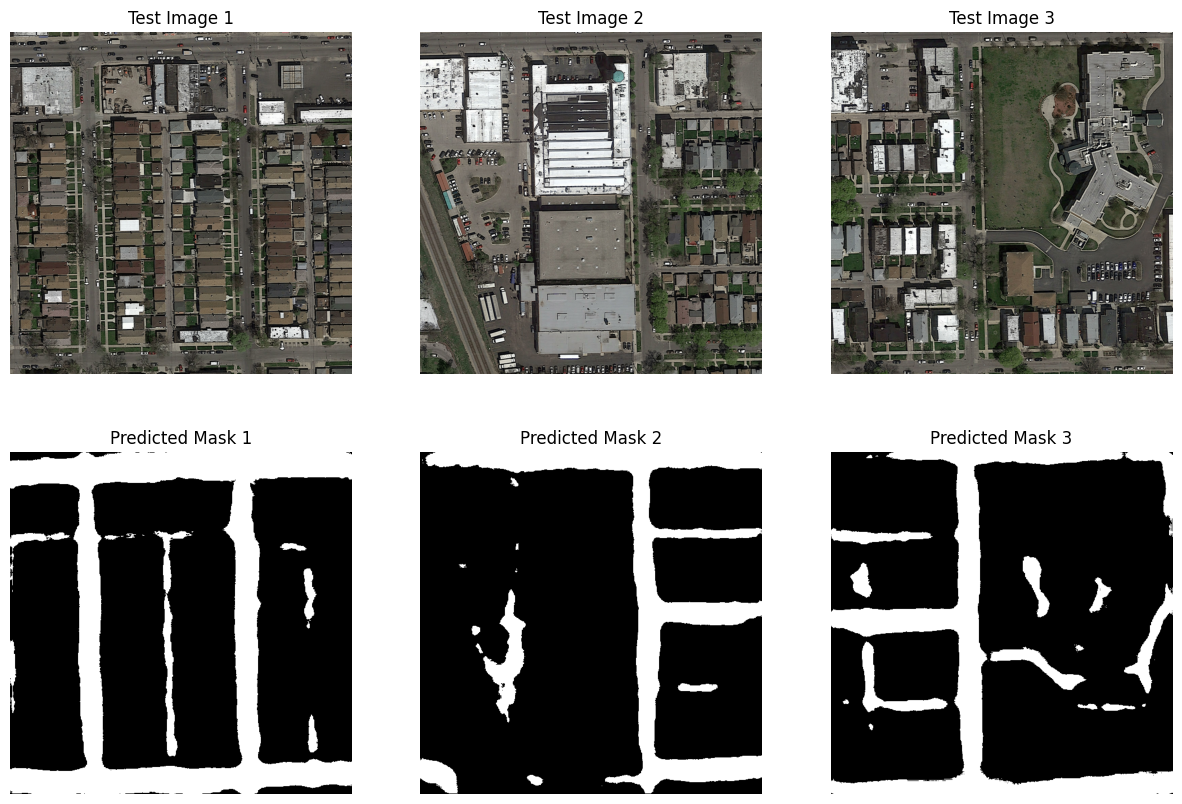

In [28]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(all_imgs[0]/255)
plt.title("Test Image 1")
plt.axis("off")
plt.subplot(2,3,2)
plt.imshow(all_imgs[1]/255)
plt.title("Test Image 2")
plt.axis("off")
plt.subplot(2,3,3)
plt.imshow(all_imgs[2]/255)
plt.title("Test Image 3")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(all_preds[0],cmap="gray")
plt.title("Predicted Mask 1")
plt.axis("off")
plt.subplot(2,3,5)
plt.imshow(all_preds[1],cmap="gray")
plt.title("Predicted Mask 2")
plt.axis("off")
plt.subplot(2,3,6)
plt.imshow(all_preds[2],cmap="gray")
plt.title("Predicted Mask 3")
plt.axis("off")
plt.savefig("/home/efe/Desktop/ml-project-2-middle_earth/figures/unet_figures/unet_predictions.png")
plt.show()


### 6.2 Train-Validation BCE Loss Plot

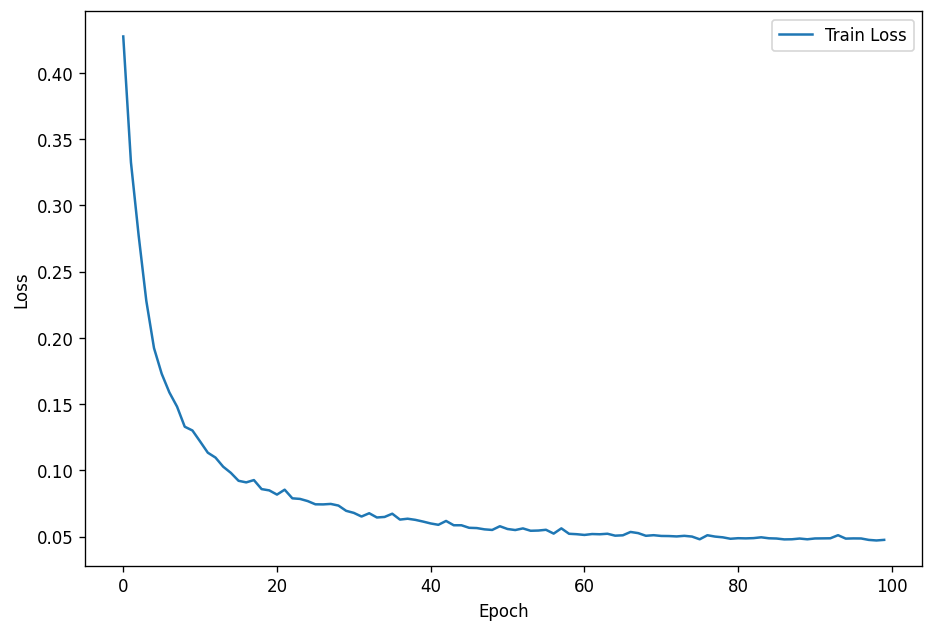

In [29]:
plt.figure(figsize=(9,6),dpi = 120)
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("/home/efe/Desktop/ml-project-2-middle_earth/figures/unet_figures/unet_losses.png")
plt.show()


### 6.3 Validation F1 Scores

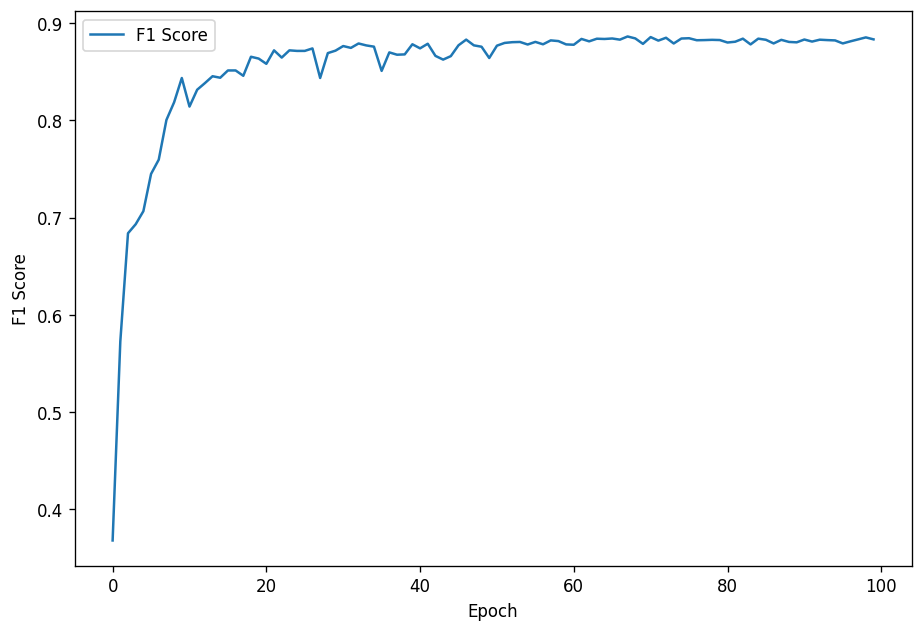

In [30]:
plt.figure(figsize=(9,6),dpi = 120)
plt.plot(f1_scores, label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("/home/efe/Desktop/ml-project-2-middle_earth/figures/unet_figures/unet_f1_scores.png")
plt.show()
